# import

In [208]:
# 데이터 처리 및 수치 계산
import pandas as pd
import numpy as np

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 폰트 및 그래프 설정
plt.rcParams["font.family"] = 'NanumGothic'     
mpl.rcParams["axes.unicode_minus"] = False     

# 경고 제거
import warnings
warnings.filterwarnings('ignore')

# 통계 분석
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 머신러닝 - 전처리, 모델링, 평가
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# 기타 설정
random_state = 42

# Jupyter에서 그래프 바로 출력
%matplotlib inline


# Power에 남은 결측치 제거하기

In [238]:
df_raw = pd.read_csv('./raw_data/updated_Car.csv', encoding='euc-kr')
df_raw.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 kmpl,998 CC,58.16 bhp,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN


In [239]:
# price 컬럼의 결측치 제거
df_raw_price = df_raw[~df_raw['Price'].isnull()]

# New_Price 컬럼 제거
df_raw_price = df_raw_price.drop(columns=['New_Price'])

In [240]:
df_raw_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6167 entries, 0 to 7194
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6167 non-null   object 
 1   Location           6167 non-null   object 
 2   Price              6167 non-null   float64
 3   Year               6167 non-null   int64  
 4   Kilometers_Driven  6167 non-null   int64  
 5   Fuel_Type          6167 non-null   object 
 6   Transmission       6167 non-null   object 
 7   Owner_Type         6167 non-null   object 
 8   Mileage            6167 non-null   object 
 9   Engine             6167 non-null   object 
 10  Power              6167 non-null   object 
 11  Seats              6167 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 626.3+ KB


* 변수들 데이터 타입 바꿔주기 및 간단한 변수 변환
    * 차량 브랜드(Brand)
    * 차량 연식(car_age)
    * 차량 주행거리(Mileage)
    * 차량 배기량(Engine)
    * 차량 파워(Power)
    * Owner type(Owner_Type)

In [241]:
def change_dtype(df):
# 사전 변수들 만들기
    # 차량 브랜드
    df['Brand'] = df['Name'].str.split(' ').str[0]
    # 차량 연식
    df['car_age'] = max(df['Year']) - df['Year']
    # 차량 주행거리
    if df['Mileage'].dtype == 'object':
        df['Mileage'] = df['Mileage'].str.split(' ').str[0].astype(float)
    # 차량 배기량
    if df['Engine'].dtype == 'object':
        df['Engine'] = df['Engine'].str.split(' ').str[0].astype(float)
    # 차량 파워
    if df['Power'].dtype == 'object':
        df['Power'] = df['Power'].str.split(' ').str[0].replace('null', np.nan).astype(float)
    # Owner type
    df['Owner_Type'] = df['Owner_Type'].replace({'First': 1, 'Second': 2, 'Third': 3, 'Fourth & Above': 4})

    return df

df_raw_price = change_dtype(df_raw_price)


In [242]:
df_raw_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6167 entries, 0 to 7194
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6167 non-null   object 
 1   Location           6167 non-null   object 
 2   Price              6167 non-null   float64
 3   Year               6167 non-null   int64  
 4   Kilometers_Driven  6167 non-null   int64  
 5   Fuel_Type          6167 non-null   object 
 6   Transmission       6167 non-null   object 
 7   Owner_Type         6167 non-null   int64  
 8   Mileage            6167 non-null   float64
 9   Engine             6167 non-null   float64
 10  Power              6060 non-null   float64
 11  Seats              6167 non-null   float64
 12  Brand              6167 non-null   object 
 13  car_age            6167 non-null   int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 722.7+ KB


Power에 결측값이 추가적으로 있다. 이거 있는거는 하나하나 찾아서 대체하자

In [243]:
df_raw_price[df_raw_price['Power'].isnull()]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,car_age
76,Ford Fiesta 1.4 SXi TDCi,Jaipur,3065.92,2008,111111,Diesel,Manual,1,17.80,1399.0,NaN,5.0,Ford,11
79,Hyundai Santro Xing XL,Hyderabad,1992.85,2005,87591,Petrol,Manual,1,0.00,1086.0,NaN,5.0,Hyundai,14
89,Hyundai Santro Xing XO,Hyderabad,3219.22,2007,73745,Petrol,Manual,1,17.00,1086.0,NaN,5.0,Hyundai,12
120,Hyundai Santro Xing XL eRLX Euro III,Mumbai,1303.02,2005,102000,Petrol,Manual,2,17.00,1086.0,NaN,5.0,Hyundai,14
143,Hyundai Santro Xing XO eRLX Euro II,Kochi,2560.04,2008,80759,Petrol,Manual,3,17.00,1086.0,NaN,5.0,Hyundai,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5840,Hyundai Santro Xing XO eRLX Euro II,Pune,1839.55,2006,47200,Petrol,Manual,2,17.00,1086.0,NaN,5.0,Hyundai,13
5860,Maruti Estilo LXI,Chennai,2682.68,2008,51000,Petrol,Manual,2,19.50,1061.0,NaN,5.0,Maruti,11
5892,Skoda Laura Classic 1.8 TSI,Pune,4368.94,2010,85000,Petrol,Manual,1,17.50,1798.0,NaN,5.0,Skoda,9
5910,Mahindra Jeep MM 540 DP,Chennai,2606.03,2002,75000,Diesel,Manual,1,0.00,2112.0,NaN,6.0,Mahindra,17


In [244]:
# 여기 있는 데이터로 위에꺼 대체해야한다. (수작업)
names_with_null_power = df_raw_price[df_raw_price['Power'].isnull()]['Name'].unique()
filtered_data = df_raw_price[df_raw_price['Name'].isin(names_with_null_power)]
filtered_data = filtered_data[filtered_data['Power'].notnull()]
filtered_data.head()



,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,car_age
12,Maruti Swift VDI BSIV,Jaipur,8584.58,2015,64424,Diesel,Manual,1,25.20,1248.0,74.00,5.0,Maruti,4
331,Maruti Swift VDI BSIV,Hyderabad,9427.70,2015,76496,Diesel,Manual,1,25.20,1248.0,74.00,5.0,Maruti,4
365,Toyota Etios GD,Kolkata,4982.12,2014,45000,Diesel,Manual,1,23.59,1364.0,67.05,5.0,Toyota,5
441,Mahindra Bolero ZLX,Coimbatore,11803.79,2016,82756,Diesel,Manual,1,15.96,2523.0,62.10,7.0,Mahindra,3
555,Toyota Etios Liva GD,Chennai,5825.25,2013,179000,Diesel,Manual,1,23.59,1364.0,67.04,5.0,Toyota,6


In [245]:
# 이 컬럼들을 대측치로 결측치를 대체해야함.
filtered_data['Name'].unique()

array(['Maruti Swift VDI BSIV', 'Toyota Etios GD', 'Mahindra Bolero ZLX',
       'Toyota Etios Liva GD', 'Toyota Etios Liva G'], dtype=object)

In [246]:
# Maruti Swift VDI BSIV 처리
df_raw_price[df_raw_price['Name'] == 'Maruti Swift VDI BSIV']

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,car_age
12,Maruti Swift VDI BSIV,Jaipur,8584.58,2015,64424,Diesel,Manual,1,25.2,1248.0,74.0,5.0,Maruti,4
226,Maruti Swift VDI BSIV,Delhi,6285.14,2013,47000,Diesel,Manual,1,17.8,1248.0,NaN,5.0,Maruti,6
307,Maruti Swift VDI BSIV,Kolkata,3832.40,2011,60020,Diesel,Manual,1,17.8,1248.0,NaN,5.0,Maruti,8
331,Maruti Swift VDI BSIV,Hyderabad,9427.70,2015,76496,Diesel,Manual,1,25.2,1248.0,74.0,5.0,Maruti,4
732,Maruti Swift VDI BSIV,Kolkata,4445.58,2012,52241,Diesel,Manual,1,25.2,1248.0,74.0,5.0,Maruti,7
737,Maruti Swift VDI BSIV,Bangalore,5212.06,2007,60000,Diesel,Manual,2,17.8,1248.0,NaN,5.0,Maruti,12
741,Maruti Swift VDI BSIV,Delhi,7511.50,2015,63000,Diesel,Manual,1,25.2,1248.0,74.0,5.0,Maruti,4
1140,Maruti Swift VDI BSIV,Bangalore,8584.58,2013,23000,Diesel,Manual,1,17.8,1248.0,NaN,5.0,Maruti,6
1183,Maruti Swift VDI BSIV,Jaipur,9044.46,2016,41460,Diesel,Manual,1,25.2,1248.0,74.0,5.0,Maruti,3
1308,Maruti Swift VDI BSIV,Delhi,6515.08,2014,57319,Diesel,Manual,1,25.2,1248.0,74.0,5.0,Maruti,5


In [247]:
mask = df_raw_price['Name'] == 'Maruti Swift VDI BSIV'
df_raw_price.loc[mask] = df_raw_price.loc[mask].fillna(74.0)

In [248]:
# Toyota Etios GD 처리
df_raw_price[df_raw_price['Name'] == 'Toyota Etios GD']

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,car_age
365,Toyota Etios GD,Kolkata,4982.12,2014,45000,Diesel,Manual,1,23.59,1364.0,67.05,5.0,Toyota,5
931,Toyota Etios GD,Kolkata,4522.23,2012,60000,Diesel,Manual,1,23.59,1364.0,NaN,5.0,Toyota,7
2099,Toyota Etios GD,Hyderabad,8891.17,2015,116000,Diesel,Manual,2,23.59,1364.0,67.05,5.0,Toyota,4
2254,Toyota Etios GD,Bangalore,6821.67,2012,58253,Diesel,Manual,2,23.59,1364.0,NaN,5.0,Toyota,7
2383,Toyota Etios GD,Chennai,4598.88,2012,150000,Diesel,Manual,3,23.59,1364.0,NaN,5.0,Toyota,7
3230,Toyota Etios GD,Chennai,7158.92,2011,79000,Diesel,Manual,1,23.59,1364.0,NaN,5.0,Toyota,8
3876,Toyota Etios GD,Coimbatore,8124.69,2013,46496,Diesel,Manual,1,23.59,1364.0,NaN,5.0,Toyota,6
5952,Toyota Etios GD,Delhi,5947.88,2013,70000,Diesel,Manual,1,23.59,1364.0,NaN,5.0,Toyota,6


In [249]:
mask = df_raw_price['Name'] == 'Toyota Etios GD'
df_raw_price.loc[mask] = df_raw_price.loc[mask].fillna(67.05)

In [250]:
# Mahindra Bolero ZLX 처리
df_raw_price[df_raw_price['Name'] == 'Mahindra Bolero ZLX']

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,car_age
441,Mahindra Bolero ZLX,Coimbatore,11803.79,2016,82756,Diesel,Manual,1,15.96,2523.0,62.1,7.0,Mahindra,3
572,Mahindra Bolero ZLX,Jaipur,9197.76,2012,105000,Diesel,Manual,2,15.96,2523.0,62.1,7.0,Mahindra,7
1143,Mahindra Bolero ZLX,Mumbai,5365.36,2016,40448,Diesel,Manual,1,15.96,2523.0,62.1,7.0,Mahindra,3
1572,Mahindra Bolero ZLX,Chennai,10730.72,2012,35000,Diesel,Manual,1,13.60,2523.0,NaN,7.0,Mahindra,7
1583,Mahindra Bolero ZLX,Jaipur,8431.28,2013,63000,Diesel,Manual,1,15.96,2523.0,62.1,7.0,Mahindra,6
5178,Mahindra Bolero ZLX,Coimbatore,12478.29,2017,68557,Diesel,Manual,1,15.96,2523.0,62.1,7.0,Mahindra,2
5324,Mahindra Bolero ZLX,Jaipur,11052.64,2016,65000,Diesel,Manual,1,15.96,2523.0,62.1,7.0,Mahindra,3
6937,Mahindra Bolero ZLX,Delhi,16770.58,2015,72253,Diesel,Manual,1,15.96,2523.0,62.1,7.0,Mahindra,4
6951,Mahindra Bolero ZLX,Kochi,16770.58,2016,78904,Diesel,Manual,1,15.96,2523.0,62.1,7.0,Mahindra,3


In [251]:
mask = df_raw_price['Name'] == 'Mahindra Bolero ZLX'
df_raw_price.loc[mask] = df_raw_price.loc[mask].fillna(62.1)

In [252]:
# Toyota Etios Liva G 처리
df_raw_price[df_raw_price['Name'] == 'Toyota Etios Liva GD']

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,car_age
555,Toyota Etios Liva GD,Chennai,5825.25,2013,179000,Diesel,Manual,1,23.59,1364.0,67.04,5.0,Toyota,6
1065,Toyota Etios Liva GD,Pune,3985.70,2012,225000,Diesel,Manual,2,23.59,1364.0,NaN,5.0,Toyota,7
1643,Toyota Etios Liva GD,Pune,5901.90,2011,32000,Diesel,Manual,1,23.59,1364.0,NaN,5.0,Toyota,8
3289,Toyota Etios Liva GD,Delhi,4752.18,2013,64000,Diesel,Manual,1,23.59,1364.0,67.06,5.0,Toyota,6
3760,Toyota Etios Liva GD,Coimbatore,8078.70,2015,49894,Diesel,Manual,1,23.59,1364.0,67.06,5.0,Toyota,4
3910,Toyota Etios Liva GD,Delhi,6668.38,2014,63000,Diesel,Manual,1,23.59,1364.0,67.04,5.0,Toyota,5
4057,Toyota Etios Liva GD,Mumbai,5518.66,2011,74000,Diesel,Manual,1,23.59,1364.0,NaN,5.0,Toyota,8
4329,Toyota Etios Liva GD,Delhi,4062.34,2012,72351,Diesel,Manual,1,23.59,1364.0,NaN,5.0,Toyota,7
4923,Toyota Etios Liva GD,Coimbatore,7158.92,2013,62601,Diesel,Manual,1,23.59,1364.0,NaN,5.0,Toyota,6


In [253]:
mask = df_raw_price['Name'] == 'Toyota Etios Liva GD'
df_raw_price.loc[mask] = df_raw_price.loc[mask].fillna(67.05)

In [254]:
# Toyota Etios Liva G 처리
df_raw_price[df_raw_price['Name'] == 'Toyota Etios Liva G']

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,car_age
826,Toyota Etios Liva G,Mumbai,3740.42,2012,29605,Petrol,Manual,1,18.30,1197.0,NaN,5.0,Toyota,7
2431,Toyota Etios Liva G,Kolkata,3357.18,2011,42118,Petrol,Manual,1,18.30,1197.0,NaN,5.0,Toyota,8
2919,Toyota Etios Liva G,Chennai,6438.43,2015,53713,Petrol,Manual,1,17.71,1197.0,78.9,5.0,Toyota,4
3758,Toyota Etios Liva G,Kochi,6990.30,2015,52207,Petrol,Manual,1,17.71,1197.0,78.9,5.0,Toyota,4
4132,Toyota Etios Liva G,Pune,5365.36,2014,80102,Petrol,Manual,1,17.71,1197.0,78.9,5.0,Toyota,5


In [255]:
mask = df_raw_price['Name'] == 'Toyota Etios Liva G'
df_raw_price.loc[mask] = df_raw_price.loc[mask].fillna(78.9)

In [256]:
df_raw_price = df_raw_price[~df_raw_price['Power'].isnull()]

---

# 이상치 처리하기

In [257]:
df_raw_price.describe()

,Price,Year,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,car_age
count,6085.000000,6085.000000,6.085000e+03,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000
mean,15057.404279,2013.539195,5.779162e+04,1.192769,18.324127,1622.924897,113.140889,5.282169,5.460805
std,17738.358355,3.171824,9.076954e+04,0.442796,4.369110,600.734396,54.106606,0.803153,3.171824
min,7.080000,1998.000000,1.710000e+02,1.000000,0.000000,624.000000,34.200000,2.000000,0.000000
25%,5518.660000,2012.000000,3.285100e+04,1.000000,15.290000,1198.000000,75.000000,5.000000,3.000000
50%,8860.510000,2014.000000,5.200000e+04,1.000000,18.440000,1493.000000,94.000000,5.000000,5.000000
75%,16096.080000,2016.000000,7.200000e+04,1.000000,21.120000,1984.000000,138.100000,5.000000,7.000000
max,245273.600000,2019.000000,6.500000e+06,4.000000,33.540000,5998.000000,616.000000,10.000000,21.000000


* 단순히 기술통계량만 봐도 이상치가 잘 보인다.
    1. Killometer_Driven : max 값이 650만km이다. -> 데이터 입력 오류로 추정
    2. Mileage : min 값이 0 이다. -> 데이터 입력 오류 or 값을 몰라서 0으로 채운것으로 추정

In [258]:
# 위에 값들 먼저 제거하기
df_raw_price = df_raw_price[df_raw_price['Kilometers_Driven']<6000000]
df_raw_price = df_raw_price[df_raw_price['Mileage']>0]

In [259]:
df_raw_price.describe()

,Price,Year,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,car_age
count,6055.000000,6055.000000,6055.000000,6055.000000,6055.000000,6055.000000,6055.000000,6055.000000,6055.000000
mean,14960.148827,2013.541866,56732.773576,1.192568,18.412277,1619.896614,112.986173,5.283567,5.458134
std,17621.603938,3.170966,37646.564043,0.442883,4.191253,597.990990,54.016852,0.804894,3.170966
min,7.080000,1998.000000,171.000000,1.000000,6.400000,624.000000,34.200000,2.000000,0.000000
25%,5518.660000,2012.000000,32852.500000,1.000000,15.350000,1198.000000,75.000000,5.000000,3.000000
50%,8814.520000,2014.000000,52000.000000,1.000000,18.490000,1493.000000,94.000000,5.000000,5.000000
75%,15881.470000,2016.000000,72000.000000,1.000000,21.135000,1968.500000,138.100000,5.000000,7.000000
max,245273.600000,2019.000000,775000.000000,4.000000,33.540000,5998.000000,616.000000,10.000000,21.000000


그래프를 그려서 이상치를 탐지하기 전에 파생변수 적용하기

In [260]:
df_raw_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6055 entries, 0 to 7194
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6055 non-null   object 
 1   Location           6055 non-null   object 
 2   Price              6055 non-null   float64
 3   Year               6055 non-null   int64  
 4   Kilometers_Driven  6055 non-null   int64  
 5   Fuel_Type          6055 non-null   object 
 6   Transmission       6055 non-null   object 
 7   Owner_Type         6055 non-null   int64  
 8   Mileage            6055 non-null   float64
 9   Engine             6055 non-null   float64
 10  Power              6055 non-null   float64
 11  Seats              6055 non-null   float64
 12  Brand              6055 non-null   object 
 13  car_age            6055 non-null   int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 709.6+ KB


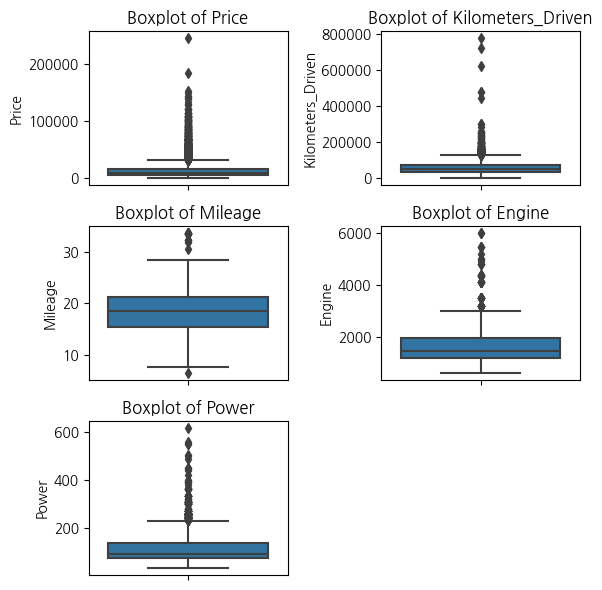

In [261]:
# 시각화 대상 컬럼 리스트
cols = ['Price', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power']

# subplot 크기 설정 (5개니까 3행 2열 정도 적당)
n_cols = 2
n_rows = (len(cols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 6))
axes = axes.flatten()  # 2D → 1D 배열로

# 각 boxplot 그리기
for i, col in enumerate(cols):
    sns.boxplot(y=col, data=df_raw_price, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    
# 남는 subplot은 제거
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Price와 Power에서 이상치로 보이는 데이터들이 보인다. 이를 처리하기 위해 IQR 방식을 사용하여 이상치를 제거할 수 있다.

In [262]:
# 1. Price 이상치 제거
Q1 = df_raw_price['Price'].quantile(0.25)
Q3 = df_raw_price['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 4 * IQR
upper_bound = Q3 + 4 * IQR
df_raw_price = df_raw_price[(df_raw_price['Price'] >= lower_bound) & (df_raw_price['Price'] <= upper_bound)]

In [263]:
# 2. Power 이상치 제거
Q1 = df_raw_price['Power'].quantile(0.25)
Q3 = df_raw_price['Power'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 4 * IQR
upper_bound = Q3 + 4 * IQR
df_raw_price = df_raw_price[(df_raw_price['Power'] >= lower_bound) & (df_raw_price['Power'] <= upper_bound)]

In [264]:
# 3. Kilometers_Driven 이상치 제거
Q1 = df_raw_price['Kilometers_Driven'].quantile(0.25)
Q3 = df_raw_price['Kilometers_Driven'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 4 * IQR
upper_bound = Q3 + 4 * IQR
df_raw_price = df_raw_price[(df_raw_price['Kilometers_Driven'] >= lower_bound) & (df_raw_price['Kilometers_Driven'] <= upper_bound)]

In [265]:
df_raw_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5796 entries, 0 to 7194
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5796 non-null   object 
 1   Location           5796 non-null   object 
 2   Price              5796 non-null   float64
 3   Year               5796 non-null   int64  
 4   Kilometers_Driven  5796 non-null   int64  
 5   Fuel_Type          5796 non-null   object 
 6   Transmission       5796 non-null   object 
 7   Owner_Type         5796 non-null   int64  
 8   Mileage            5796 non-null   float64
 9   Engine             5796 non-null   float64
 10  Power              5796 non-null   float64
 11  Seats              5796 non-null   float64
 12  Brand              5796 non-null   object 
 13  car_age            5796 non-null   int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 679.2+ KB


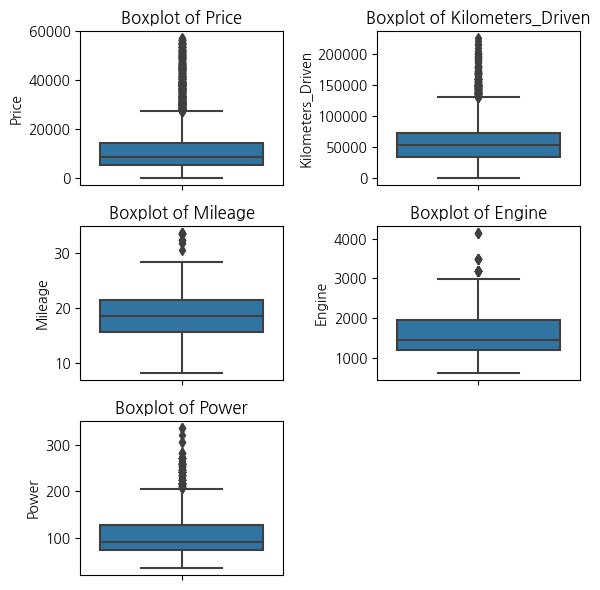

In [266]:
# 시각화 대상 컬럼 리스트
cols = ['Price', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power']

# subplot 크기 설정 (5개니까 3행 2열 정도 적당)
n_cols = 2
n_rows = (len(cols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 6))
axes = axes.flatten()  # 2D → 1D 배열로

# 각 boxplot 그리기
for i, col in enumerate(cols):
    sns.boxplot(y=col, data=df_raw_price, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    
# 남는 subplot은 제거
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 파생 변수 생성

In [267]:
def make_new_parameter(df):
# 사전 변수들 만들기
    # 1. Power / Engine (연료 대비 파워) : Power_per_Engine
    df['Power_per_Engine'] = df['Power'] / df['Engine']

    # 2.Kilometers_Driven/car age (연식 대비 주행거리) : Mileage_per_car_age
    df['Mileage_per_car_age'] = df['Mileage'] / df['car_age']

    # 3. Kilometers_Driven/Owner_Type (차량 소유자 유형 대비 주행거리) : Kilometers_Driven_Owner_Type
    df['Kilometers_Driven_Owner_Type'] = df['Kilometers_Driven'] / df['Owner_Type']

    # 4. car_age/Owner_Type (차량 소유자 유형 대비 연식) : car_age_Owner_Type
    df['car_age_Owner_Type'] = df['car_age'] / df['Owner_Type']

    # 5. 1번 변수 범주화 해야함.....

    # 6. 도시 범주화 해야함.
    tier_1_cities = ['Mumbai', 'Pune', 'Chennai', 'Hyderabad', 'Kolkata', 'Delhi', 'Bangalore', 'Ahmedabad']
    tier_2_cities = ['Jaipur', 'Kochi', 'Coimbatore']
    def classify_city_tier(location):
        if location in tier_1_cities:
            return 'Tier_1'
        elif location in tier_2_cities:
            return 'Tier_2'
        else:
            return 'Other' 
    df['Location'] = df['Location'].apply(classify_city_tier)
    # 7. 연간가치 하락률

    # 8. new_price만 할 수 있는 범주화

    # 9. 차 브랜드 범주화
    
    luxury_brands = [
        'Audi', 'BMW', 'Mercedes-Benz', 'Porsche', 'Jaguar',
        'Land',  
        'Volvo', 'Mini', 'Bentley', 'Lamborghini'
    ]
    mid_range_brands = [
        'Hyundai', 'Honda', 'Nissan', 'Toyota', 'Volkswagen',
        'Ford', 'Skoda', 'Renault', 'Jeep', 'Mitsubishi',
        'Chevrolet'
    ]
    budget_brands = [
        'Maruti',  
        'Tata',
        'Mahindra',
        'Datsun',
        'Fiat',
        'Ambassador',
        'ISUZU',
        'Force'
    ]
    def classify_brand_tier(brand):
        if brand in luxury_brands:
            return 'Luxury'
        elif brand in mid_range_brands:
            return 'Mid_Range'
        elif brand in budget_brands:
            return 'Budget'
        else:
            return 'Other' 
    
    df['Brand'] = df['Brand'].apply(classify_brand_tier)

    # 10. Power / Seats (파워 대비 좌석수) : Power_per_Seats
    df['Power_per_Seats'] = df['Power'] / df['Seats']

    return df

In [268]:
df_raw_price = make_new_parameter(df_raw_price)

In [269]:
df_raw_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5796 entries, 0 to 7194
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          5796 non-null   object 
 1   Location                      5796 non-null   object 
 2   Price                         5796 non-null   float64
 3   Year                          5796 non-null   int64  
 4   Kilometers_Driven             5796 non-null   int64  
 5   Fuel_Type                     5796 non-null   object 
 6   Transmission                  5796 non-null   object 
 7   Owner_Type                    5796 non-null   int64  
 8   Mileage                       5796 non-null   float64
 9   Engine                        5796 non-null   float64
 10  Power                         5796 non-null   float64
 11  Seats                         5796 non-null   float64
 12  Brand                         5796 non-null   object 
 13  car

In [270]:
df_raw_price.to_csv('processed_Car.csv', index = False)

In [7]:
# Name : 자동차 메인 브랜드만 추출
df_raw_price['Brand'] = df_raw_price['Name'].str.split(' ').str[0]

# Year : 데이터 수집이 2019년(max)이라고 가정하고 몇년됐는지?
df_raw_price['For_year'] = max(df_raw_price['Year']) - df_raw_price['Year']

# Mileage : 연비 : 문자열로 돼있음 + 연비가 0으로 돼있는게 있다.(68개) -> 이거를 결측치로 봐야할듯함.
df_raw_price['Mileage_num']=df_raw_price['Mileage'].str.split(' ').str[0].astype(float)

# Engine :  문자열로 돼있음 -> 전기차가 배기량이 77임....전기차는 거르는게 맞나요?? 안거를려고 했는데.....일단 기다려보자
df_raw_price['Engine_num']=df_raw_price['Engine'].str.split(' ').str[0].astype(float)

# Power
df_raw_price['Power_num'] = (df_raw_price['Power'].str.split(' ').str[0].replace('null', np.nan) .astype(float))

# new price 일단 드랍 할게요~
df_raw_price = df_raw_price.drop(columns=['New_Price'])

# 결측값 싹 다 지워~~~
df_raw_price.dropna(inplace=True)

In [8]:
df_raw_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6053 entries, 0 to 7236
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6053 non-null   object 
 1   Location           6053 non-null   object 
 2   Price              6053 non-null   float64
 3   Year               6053 non-null   int64  
 4   Kilometers_Driven  6053 non-null   int64  
 5   Fuel_Type          6053 non-null   object 
 6   Transmission       6053 non-null   object 
 7   Owner_Type         6053 non-null   object 
 8   Mileage            6053 non-null   object 
 9   Engine             6053 non-null   object 
 10  Power              6053 non-null   object 
 11  Seats              6053 non-null   float64
 12  Brand              6053 non-null   object 
 13  For_year           6053 non-null   int64  
 14  Mileage_num        6053 non-null   float64
 15  Engine_num         6053 non-null   float64
 16  Power_num          6053 

In [9]:
# 준규형이랑 합치기 전에 column명 통일하기!!!

def make_new_parameter(df):
# 사전 변수들 만들기
    # 차량 브랜드
    df['Brand'] = df['Name'].str.split(' ').str[0]
    # 차량 연식
    df['car_age'] = max(df['Year']) - df['Year']
    # 차량 주행거리
    if df['Mileage'].dtype == 'object':
        df['Mileage'] = df['Mileage'].str.split(' ').str[0].astype(float)
    # 차량 배기량
    if df['Engine'].dtype == 'object':
        df['Engine'] = df['Engine'].str.split(' ').str[0].astype(float)
    # 차량 파워
    if df['Power'].dtype == 'object':
        df['Power'] = df['Power'].str.split(' ').str[0].replace('null', np.nan).astype(float)
    # Owner type
    df['Owner_Type'] = df['Owner_Type'].replace({'First': 1, 'Second': 2, 'Third': 3, 'Fourth & Above': 4})

    # 1. Power / Engine (연료 대비 파워) : Power_per_Engine
    df['Power_per_Engine'] = df['Power'] / df['Engine']

    # 2.Kilometers_Driven/car age (연식 대비 주행거리) : Mileage_per_car_age
    df['Mileage_per_car_age'] = df['Mileage'] / df['car_age']

    # 3. Kilometers_Driven/Owner_Type (차량 소유자 유형 대비 주행거리) : Kilometers_Driven_Owner_Type
    df['Kilometers_Driven_Owner_Type'] = df['Kilometers_Driven'] / df['Owner_Type']

    # 4. car_age/Owner_Type (차량 소유자 유형 대비 연식) : car_age_Owner_Type
    df['car_age_Owner_Type'] = df['car_age'] / df['Owner_Type']

    # 5. 1번 변수 범주화 해야함.....

    # 6. 도시 범주화 해야함.

    # 7. 연간가치 하락률

    # 8. new_price만 할 수 있는 범주화

    # 9. 차 브랜드 범주화

    # 10. Power / Seats (파워 대비 좌석수) : Power_per_Seats
    df['Power_per_Seats'] = df['Power'] / df['Seats']

    return df


In [10]:
df_new = make_new_parameter(df_raw_price)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6053 entries, 0 to 7236
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          6053 non-null   object 
 1   Location                      6053 non-null   object 
 2   Price                         6053 non-null   float64
 3   Year                          6053 non-null   int64  
 4   Kilometers_Driven             6053 non-null   int64  
 5   Fuel_Type                     6053 non-null   object 
 6   Transmission                  6053 non-null   object 
 7   Owner_Type                    6053 non-null   int64  
 8   Mileage                       6053 non-null   float64
 9   Engine                        6053 non-null   float64
 10  Power                         6053 non-null   float64
 11  Seats                         6053 non-null   float64
 12  Brand                         6053 non-null   object 
 13  For

<Axes: xlabel='Power_per_Engine', ylabel='Count'>

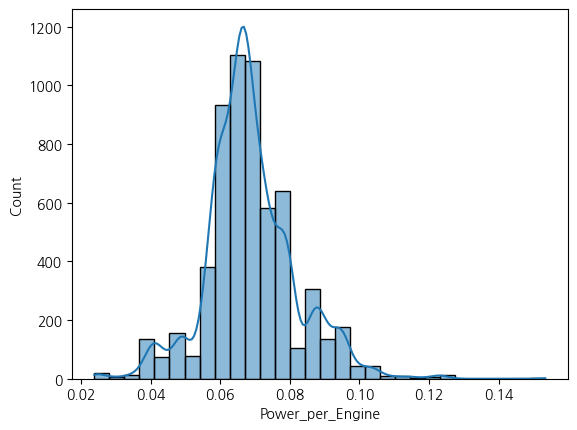

In [11]:
sns.histplot(df_new['Power_per_Engine'], bins=30, kde=True)
# df_new['Power_per_Engine'] 이거를 범주화도 시키고 싶은데 어떤거 기준으로 하면 될까?


In [ ]:
# Power_per_Engine을 4분위수로 범주화
df_new['Power_per_Engine_Q4'] = pd.qcut(df_new['Power_per_Engine'], 
                                        q=4, 
                                        labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# 결과 확인
print("=== Power_per_Engine 4분위수 범주화 결과 ===")
print(df_new['Power_per_Engine_Q4'].value_counts().sort_index())

# 각 그룹의 기본 통계량
print("\n=== 각 그룹별 Power_per_Engine 통계량 ===")
print(df_new.groupby('Power_per_Engine_Q4')['Power_per_Engine'].describe())